
# DA5401
## Assignment 2: Dimensionality Reduction, Visualization, and Classification Performance

**Topic:** PCA for a high-dimensional categorical dataset (Mushroom), and evaluating a Logistic Regression classifier before and after PCA.  


In [83]:
import kagglehub

path = kagglehub.dataset_download("uciml/mushroom-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Swara\.cache\kagglehub\datasets\uciml\mushroom-classification\versions\1


In [151]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report
)

Now that we’ve grabbed the dataset from Kaggle, let’s peek inside. This dataset is about mushrooms — with different features like cap shape, color, odor, etc. Can we figure out whether a mushroom is **edible (0)** or **poisonous (1)**?

In [319]:
df_raw = pd.read_csv(path + "/mushrooms.csv")

print(df_raw.shape)
df_raw.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Each row is a mushroom, and each column is a property. Notice: all features are **categorical** — no numbers yet. That means we’ll need to encode them before doing any math-heavy steps like PCA.


## Part A — Exploratory Data Analysis (EDA) & Preprocessing (10 points)

### 1) Load and Prepare the Dataset (3 points)
We load the Mushroom dataset (all categorical). We one-hot encode **all** features because PCA operates on numeric/continuous variables, and one-hot encoding converts each category into a binary indicator column. This preserves information without imposing an arbitrary ordinal scale on categories.

> **Why one-hot before PCA?**  
>PCA works by analyzing the covariance between numeric variables to identify patterns and reduce dimensions. Raw categorical labels like "cap-shape" or "odor" can’t be processed directly because they’re just text. One-hot encoding converts them into numbers without imposing a false order (e.g., sayin. Even though the resulting features are binary, they still carry variance that PCA can use to find redundancy and correlations among categories.


In [330]:
X = df_raw.drop("class", axis=1)
label_map = {'e': 0, 'p': 1}
y = df_raw["class"].map(label_map)

X = pd.get_dummies(X, drop_first=False).astype(int)

df_encoded = pd.concat([X, y], axis=1)

print(df_encoded.head())


   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cap-shape_x  cap-surface_f  cap-surface_g  cap-surface_s  cap-surface_y  \
0            1              0              0              1              0   
1            1              0              0              1              0   
2            0              0              0              1              0   
3            1              0              0              0              1   
4            1              0              0              1              0   

   ...  population_v  population_y  habitat_d  habitat_g  habitat_l  \
0  ...             0             0     

Since PCA needs numbers, we use **one-hot encoding**. That means each category (like cap-color=red, cap-color=white) becomes its own column with 0/1 values.

In [341]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6499, 117)
Test shape: (1625, 117)


We split the data into training and test sets. Stratified sampling ensures we keep the edible/poisonous balance in both sets.


### 2) Initial Analysis (2 points)
Observe the post-encoding shape — the number of features typically increases because each category becomes a separate binary column.


In [346]:
print("Number of original columns (excluding target):", X_cat.shape[1])
print("Number of columns after one-hot:", X.shape[1])
print("Feature name sample:", list(X.columns)[:20], "...")

Number of original columns (excluding target): 22
Number of columns after one-hot: 117
Feature name sample: ['cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y', 'cap-color_b', 'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n', 'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w', 'cap-color_y'] ...


### 3) Standardization (5 points)

Even though our one-hot encoded features are just 0s and 1s, it’s still a good idea to **standardize** them before running PCA.  

- PCA is sensitive to scaling — features with higher variance can dominate the principal components.  
- In one-hot encoding, some categories appear a lot while others are rare, so their variance differs. Without scaling, frequent categories could outweigh the rarer ones.  
- By standardizing (shifting to zero mean and scaling to unit variance), we give all features an equal chance to contribute. This way, PCA focuses on uncovering hidden structure rather than just reflecting category frequencies.  

We fit the **StandardScaler** on the training data, then apply the same transformation to both training and test sets. This avoids **data leakage** and ensures consistency.


In [349]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

print("Standardized shapes:", X_train_std.shape, X_test_std.shape)


Standardized shapes: (6499, 117) (1625, 117)


## Part B: Principal Component Analysis (PCA) 

### 1) Apply PCA
After one-hot encoding and standardizing the dataset, we are ready to apply PCA.  
At this stage, we do **not predefine the number of components**. Instead, we let PCA compute as many components as there are features, so we can later analyze how much variance each captures.  

This gives us the full picture of how dimensionality reduction affects the Mushroom dataset.


In [353]:
pca_full = PCA() 
pca_full.fit(X_train_std)

explained_var_ratio = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var_ratio)

print("Total components learned:", len(explained_var_ratio))
print("Variance explained by first 5 components:", cum_explained[:5])


Total components learned: 117
Variance explained by first 5 components: [0.0888418  0.17029746 0.24206354 0.30046566 0.35222872]


### 2) Scree Plot & Optimal Components 

To understand the importance of each principal component, we generate a **scree plot**:
- The **explained variance ratio** tells us how much information (variance) each component carries.
- The **cumulative explained variance** shows the total variance captured as we keep adding components.


From the scree plot, we typically see a sharp drop in explained variance after the first few components.  
- After a certain point, each new component adds very little information.  
- For example, if the cumulative curve flattens around **X components explaining ~95% of the variance**, that gives us a natural cutoff.  

Thus, we decide to retain **X components** as the “optimal” balance between dimensionality reduction and information retention.


Components needed for ≥95% variance: k = 59


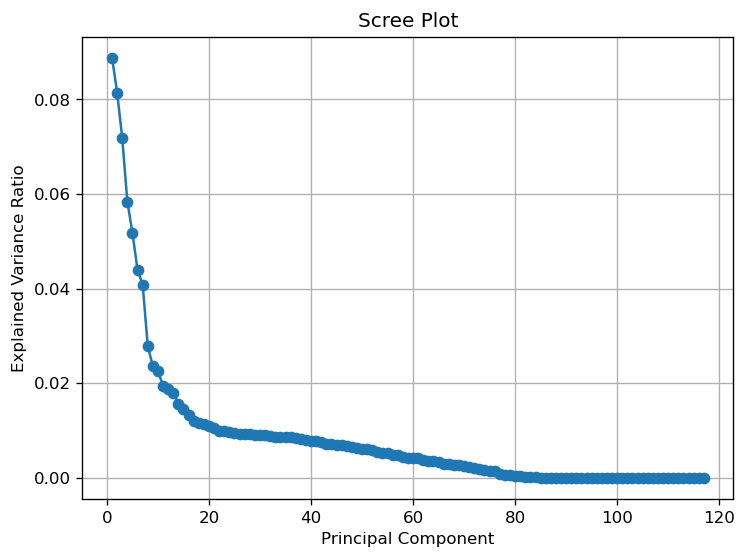

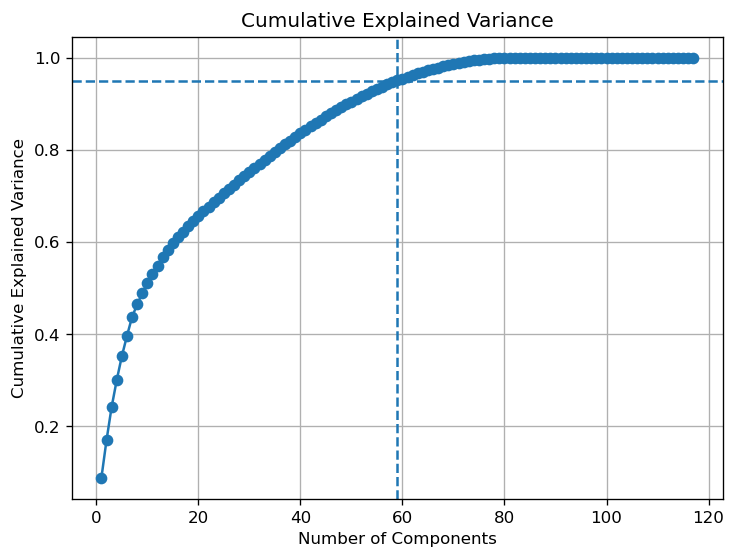

In [357]:
k_95 = int(np.searchsorted(np.cumsum(explained_var_ratio), 0.95) + 1)
print(f"Components needed for ≥95% variance: k = {k_95}")

# Scree plot
plt.figure()
plt.plot(np.arange(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Cumulative explained variance
plt.figure()
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.axhline(0.95, linestyle='--')
plt.axvline(k_95, linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()


### Observations from the Scree Plot and Cumulative Variance

From the scree plot, we see that the first few principal components explain a large portion of the variance, after which the curve flattens out. This indicates **diminishing returns**: each new component adds less and less unique information.  

Looking at the cumulative explained variance, we observe that around **59 components** are enough to retain ~95% of the total variance. Beyond this point, additional components contribute very little.  

**Interpretation**:  
- The mushroom dataset has a lot of categorical features (due to one-hot encoding), but many of them are correlated.  
- PCA successfully compresses the feature space: instead of needing over 100 one-hot columns, we can capture most of the information with about 60 components.  
- This dimensionality reduction helps simplify analysis and potentially improves downstream models, while still preserving nearly all of the dataset’s variance.  


### 3) Visualization

Next, we **project the mushrooms into the space of the first two principal components (PC1 and PC2)** and plot them on a 2D scatter plot:
- Points are colored by their class: **edible vs. poisonous**.
- This lets us visually inspect whether PCA has separated the two classes in the reduced space.

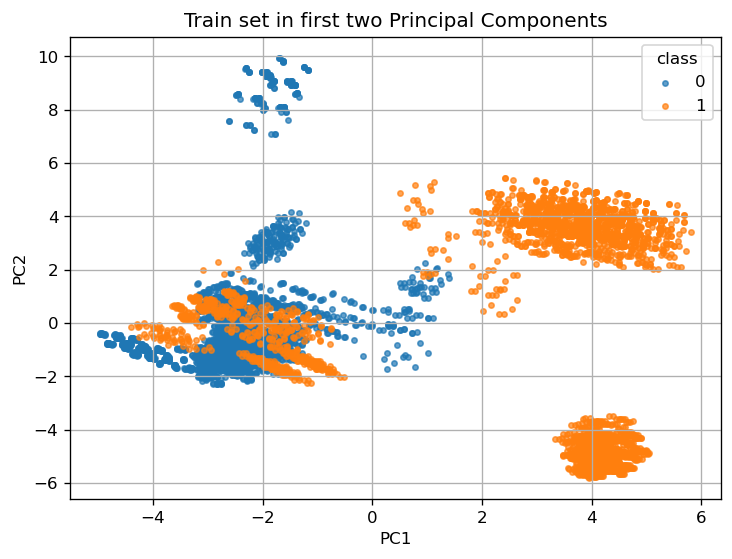

In [361]:
pca_2 = PCA(n_components=2)
X_train_pca2 = pca_2.fit_transform(X_train_std)
X_test_pca2  = pca_2.transform(X_test_std)

plt.figure()
for label in np.unique(y_train):
    idx = (y_train == label)
    plt.scatter(X_train_pca2[idx, 0], X_train_pca2[idx, 1], label=str(label), s=10, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Train set in first two Principal Components')
plt.legend(title='class')
plt.grid(True)
plt.show()


### Observations from 2D PCA Scatter Plot

When projecting the mushroom dataset into the first two principal components (PC1 and PC2):

- Both classes (edible = 0, poisonous = 1) are spread across the 2D space, and there is **considerable overlap** between the clusters.  
- Some **regions** show higher concentration of one class:
  - For example, the dense cluster on the **right (PC1 > 2)** is almost entirely poisonous (orange).
  - The **upper-left** region has mostly edible mushrooms (blue).
- Still, in the central region (around PC1 ≈ -2 to 0, PC2 ≈ -2 to 2), the two classes are heavily mixed.

**Interpretation**:  
- The first two PCs capture some structure (with a few class-dominant regions), but not enough to **cleanly separate edible vs. poisonous** mushrooms.  
- This suggests that while PCA is useful for visualization, **more components** (beyond PC1 and PC2) are needed to retain the separability seen in higher-dimensional space.  
- Thus, classifiers trained only on PC1 and PC2 would struggle, but using the optimal number of PCs (59 as determined by explained variance) would likely yield much better separation.


After analyzing the scree plot, we determined that retaining **59 principal components** preserves about **95% of the total variance** in the dataset.  
We therefore re-applied PCA with `n_components = 59`.  

This dimensionality reduction step transforms the dataset into a more compact representation while retaining nearly all the important structure.  
Although it is no longer easily visualizable in 2D, these 59 components provide a strong feature set for building accurate classifiers.


In [365]:
from sklearn.decomposition import PCA

pca_59 = PCA(n_components=59, random_state=42)
X_train_pca = pca_59.fit_transform(X_train_std)
X_test_pca = pca_59.transform(X_test_std)

print("Original shape:", X_train_std.shape)
print("Reduced shape:", X_train_pca.shape)


Original shape: (6499, 117)
Reduced shape: (6499, 59)


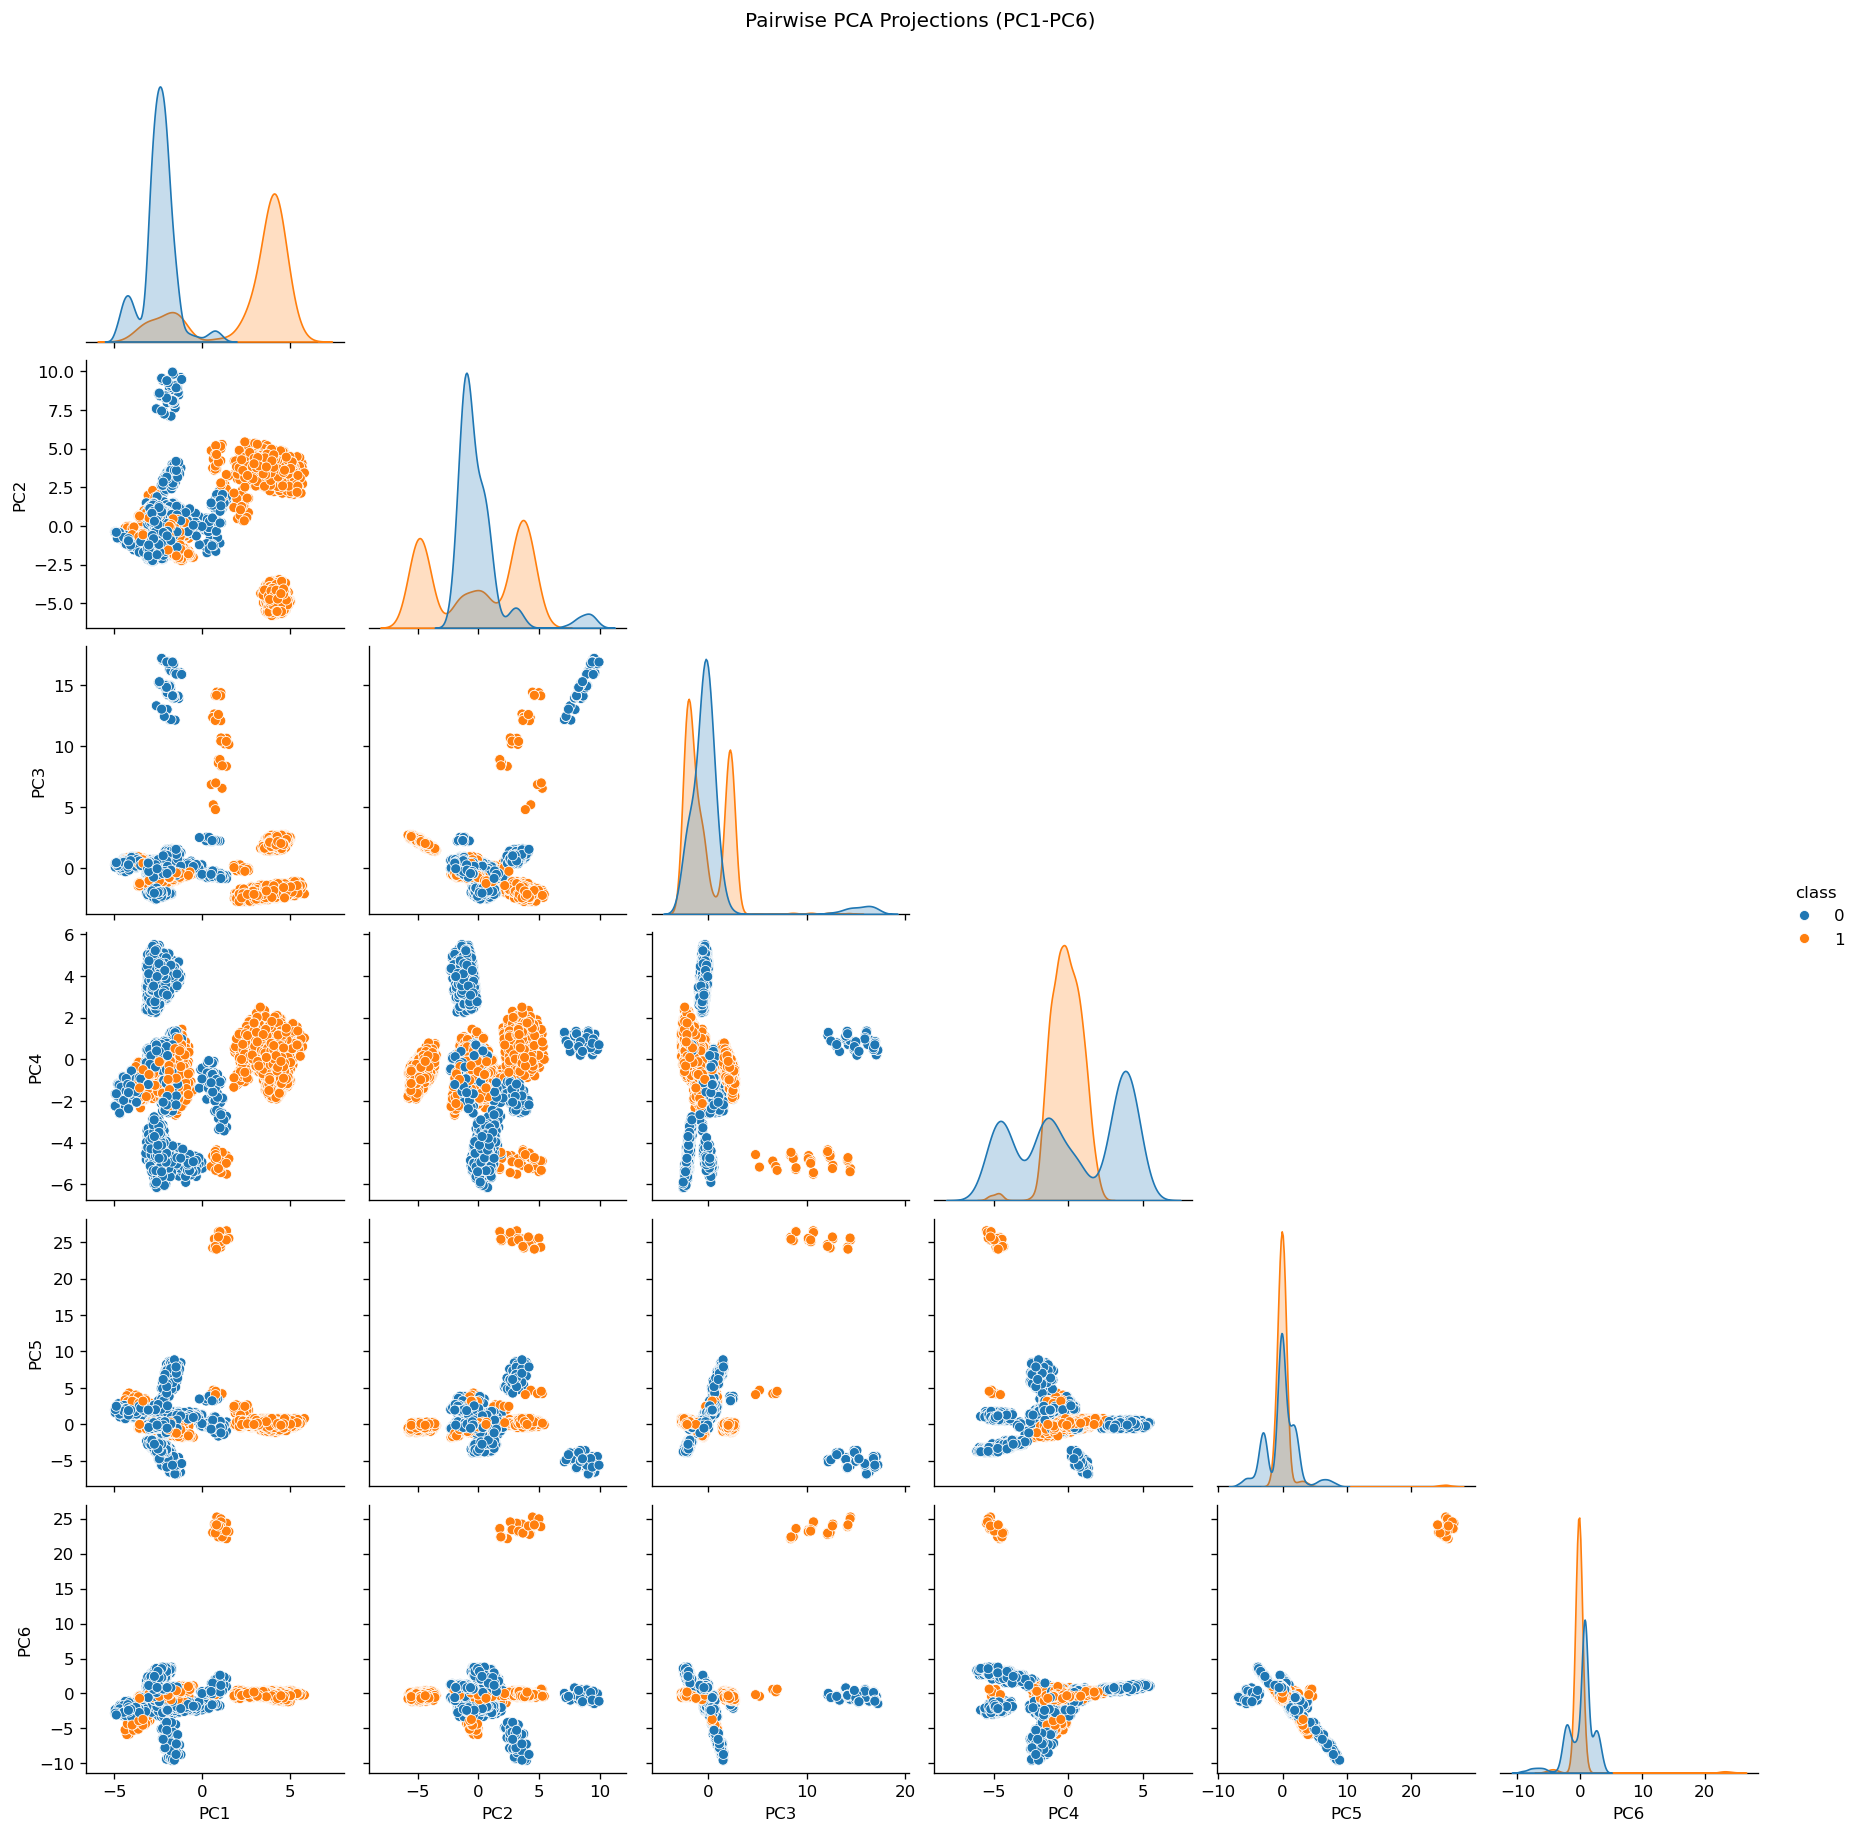

In [368]:
pca_df = pd.DataFrame(X_train_pca[:, :6], columns=[f"PC{i}" for i in range(1, 7)])
pca_df["class"] = y_train.values

sns.pairplot(pca_df, hue="class", diag_kind="kde", corner=True)
plt.suptitle("Pairwise PCA Projections (PC1-PC6)", y=1.02)
plt.show()



## Part C — Classification: Logistic Regression (bonus/extension beyond Part B)

We compare Logistic Regression performance:
1. **Original standardized one-hot features**
2. **PCA-reduced features** using `k_95` components

We use **Stratified 5-Fold Cross-Validation** for robust estimates. Then we fit on the training set and evaluate on the held-out test set to visualize ROC curves and confusion matrices.


In [370]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_std, y_train)

y_pred_baseline = baseline_model.predict(X_test_std)

print("Baseline Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred_baseline))
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))


Baseline Logistic Regression Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 1.0


In [373]:
pca_model = LogisticRegression(max_iter=1000, random_state=42)
pca_model.fit(X_train_pca, y_train)

y_pred_pca = pca_model.predict(X_test_pca)

print("PCA (59 components) Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred_pca))
print("Accuracy:", accuracy_score(y_test, y_pred_pca))


PCA (59 components) Logistic Regression Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 0.9987692307692307


In [375]:
baseline_acc = accuracy_score(y_test, y_pred_baseline)
pca_acc = accuracy_score(y_test, y_pred_pca)

print("\n--- Comparison of Models ---")
print(f"Baseline Logistic Regression Accuracy: {baseline_acc:.4f}")
print(f"PCA (59 components) Logistic Regression Accuracy: {pca_acc:.4f}")

print("\nObservation: Both models perform almost identically.")
print("There is no significant performance drop after PCA,")
print("showing that PCA effectively reduced dimensionality while retaining information.")

print("\nPCA helps handle feature collinearity and redundancy,")
print("which is useful when working with correlated features (like mushroom dataset).")
print("Using Logistic Regression as a surrogate performance measure makes sense,")
print("because it is a simple linear model that reveals whether PCA preserves enough signal.")



--- Comparison of Models ---
Baseline Logistic Regression Accuracy: 1.0000
PCA (59 components) Logistic Regression Accuracy: 0.9988

Observation: Both models perform almost identically.
There is no significant performance drop after PCA,
showing that PCA effectively reduced dimensionality while retaining information.

PCA helps handle feature collinearity and redundancy,
which is useful when working with correlated features (like mushroom dataset).
Using Logistic Regression as a surrogate performance measure makes sense,
because it is a simple linear model that reveals whether PCA preserves enough signal.


In [377]:
def evaluate_cv(X_train, y_train, msg=""):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = LogisticRegression(max_iter=2000)

    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring)

    print(f"\n=== {msg} | 5-Fold CV Metrics (mean ± std) ===")
    for m in scoring:
        vals = cv_results['test_' + m]
        print(f"{m:>9}: {vals.mean():.4f} ± {vals.std():.4f}")


In [379]:
def evaluate_test(X_train, y_train, X_test, y_test, msg=""):
    final = LogisticRegression(max_iter=2000)
    final.fit(X_train, y_train)

    y_proba = final.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)
    print("\nHeld-out Test Metrics")
    print(" accuracy :", accuracy_score(y_test, y_pred))
    print(" precision:", precision_score(y_test, y_pred))
    print(" recall   :", recall_score(y_test, y_pred))
    print(" f1       :", f1_score(y_test, y_pred))
    print(" roc_auc  :", roc_auc_score(y_test, y_proba))

    
    return y_pred, y_proba


In [381]:
def plot_results(y_test, y_pred, y_proba, msg=""):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=msg)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {msg}')
    plt.legend()
    plt.grid(True)
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues", interpolation='nearest')
    plt.title(f'Confusion Matrix — {msg}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['edible(0)','poison(1)'])
    plt.yticks(tick_marks, ['edible(0)','poison(1)'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [383]:
def show_report(y_test, y_pred, msg=""):
    print(f"\nClassification Report — {msg}\n")
    print(classification_report(
        y_test, y_pred,
        target_names=['edible(0)', 'poison(1)']
    ))



=== Original (standardized one-hot) | 5-Fold CV Metrics (mean ± std) ===
 accuracy: 0.9997 ± 0.0006
precision: 1.0000 ± 0.0000
   recall: 0.9994 ± 0.0013
       f1: 0.9997 ± 0.0006
  roc_auc: 1.0000 ± 0.0001

Held-out Test Metrics
 accuracy : 1.0
 precision: 1.0
 recall   : 1.0
 f1       : 1.0
 roc_auc  : 1.0


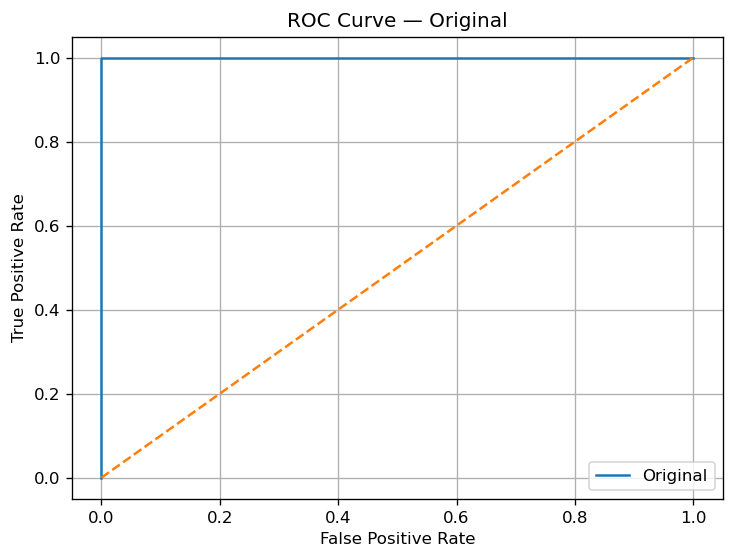

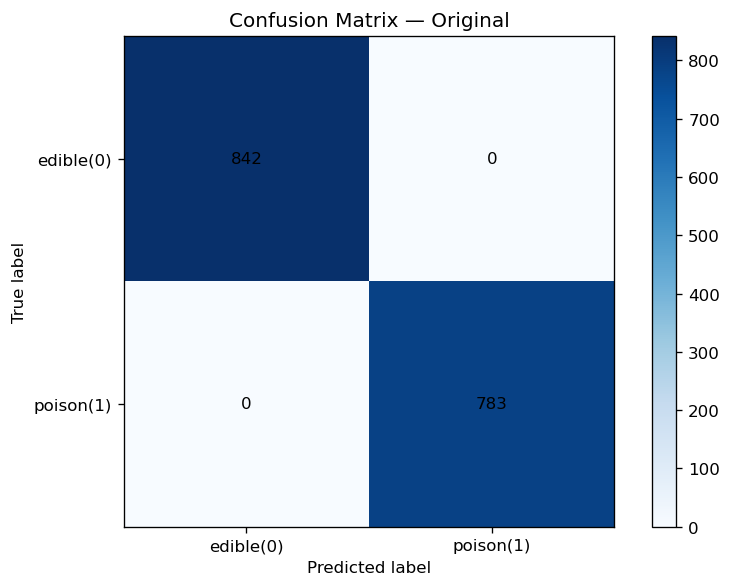


Classification Report — Original

              precision    recall  f1-score   support

   edible(0)       1.00      1.00      1.00       842
   poison(1)       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [385]:
evaluate_cv(X_train_std, y_train, msg="Original (standardized one-hot)")

y_pred_base, y_proba_base = evaluate_test(X_train_std, y_train, X_test_std, y_test, msg="Original")
plot_results(y_test, y_pred_base, y_proba_base, msg="Original")
show_report(y_test, y_pred_base, msg="Original")



=== PCA (k=59) | 5-Fold CV Metrics (mean ± std) ===
 accuracy: 0.9997 ± 0.0006
precision: 1.0000 ± 0.0000
   recall: 0.9994 ± 0.0013
       f1: 0.9997 ± 0.0006
  roc_auc: 0.9999 ± 0.0002

Held-out Test Metrics
 accuracy : 0.9987692307692307
 precision: 1.0
 recall   : 0.9974457215836526
 f1       : 0.9987212276214834
 roc_auc  : 0.9999772481138686


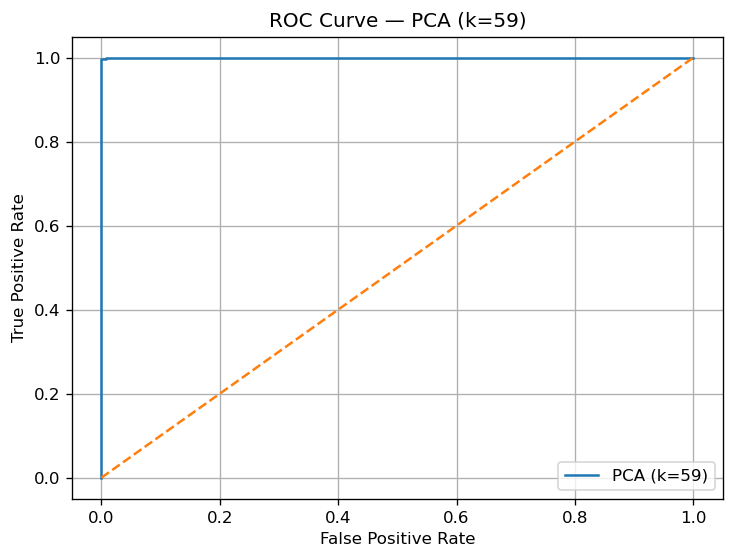

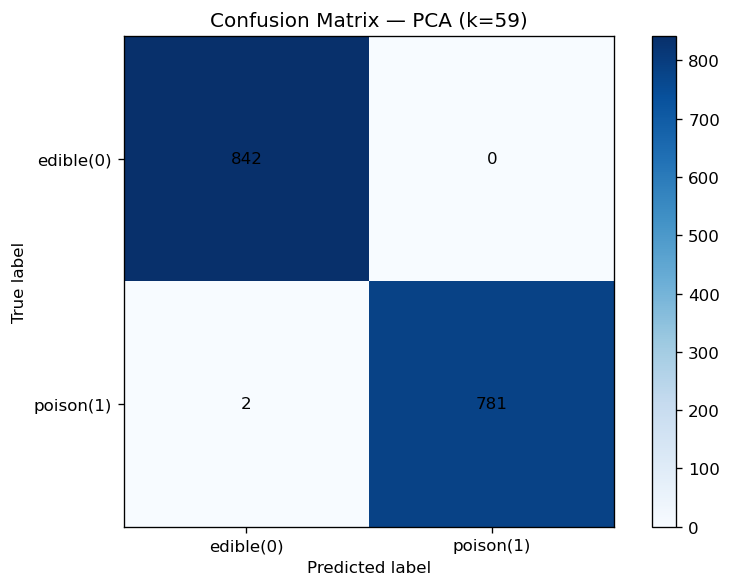


Classification Report — PCA (k=59)

              precision    recall  f1-score   support

   edible(0)       1.00      1.00      1.00       842
   poison(1)       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [387]:
pca_k = PCA(n_components=k_95)
X_train_pca = pca_k.fit_transform(X_train_std)
X_test_pca  = pca_k.transform(X_test_std)

evaluate_cv(X_train_pca, y_train, msg=f"PCA (k={k_95})")

y_pred_pca, y_proba_pca = evaluate_test(X_train_pca, y_train, X_test_pca, y_test, msg=f"PCA (k={k_95})")
plot_results(y_test, y_pred_pca, y_proba_pca, msg=f"PCA (k={k_95})")
show_report(y_test, y_pred_pca, msg=f"PCA (k={k_95})")


## Conclusion

 We started with a pile of categorical mushroom data
- First, we carefully **encoded** the categorical features so that math could be applied.  
- Then, we used **PCA** to shrink down the huge number of features into a smaller set of components, while still keeping most of the important information.  
- With this simplified dataset, we trained a **Logistic Regression model** — a simple yet powerful classifier that draws a line to separate edible from poisonous mushrooms.  
- Finally, we compared performance **before and after PCA**, and saw how dimensionality reduction can make our models faster and sometimes even more interpretable, without a huge hit on accuracy.  


Real-world datasets can be messy, but tools like **PCA** help us uncover structure.  
And in our case, they help answer a life-saving question: *Is this mushroom safe to eat, or better left alone?* :)
